In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sn
import pandas as pd
import pickle

from mnist import Mnist
from rbm import RBM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mpl_toolkits.axes_grid1 import Grid

In [2]:
# get data from MNIST dataset
mnist = Mnist()
train_X, train_label = mnist.get_trainset(norm=True)
test_X, test_label = mnist.get_testset(norm=True)

In [3]:
# create and train RBM
print("Training RBM")
rbm = RBM(mnist.IMG_SIZE*mnist.IMG_SIZE, 100)
rbm.cd(train_X, epoch=5, batch_size=1, k=1, verbose=True)

Training RBM
Epoch: 0 - batch: 0.0
Epoch: 0 - batch: 5000.0
Epoch: 0 - batch: 10000.0
Epoch: 0 - batch: 15000.0
Epoch: 0 - batch: 20000.0
Epoch: 0 - batch: 25000.0
Epoch: 0 - batch: 30000.0
Epoch: 0 - batch: 35000.0
Epoch: 0 - batch: 40000.0
Epoch: 0 - batch: 45000.0
Epoch: 0 - batch: 50000.0
Epoch: 0 - batch: 55000.0
Epoch: 1 - batch: 0.0
Epoch: 1 - batch: 5000.0
Epoch: 1 - batch: 10000.0
Epoch: 1 - batch: 15000.0
Epoch: 1 - batch: 20000.0
Epoch: 1 - batch: 25000.0
Epoch: 1 - batch: 30000.0
Epoch: 1 - batch: 35000.0
Epoch: 1 - batch: 40000.0
Epoch: 1 - batch: 45000.0
Epoch: 1 - batch: 50000.0
Epoch: 1 - batch: 55000.0
Epoch: 2 - batch: 0.0
Epoch: 2 - batch: 5000.0
Epoch: 2 - batch: 10000.0
Epoch: 2 - batch: 15000.0
Epoch: 2 - batch: 20000.0
Epoch: 2 - batch: 25000.0
Epoch: 2 - batch: 30000.0
Epoch: 2 - batch: 35000.0
Epoch: 2 - batch: 40000.0
Epoch: 2 - batch: 45000.0
Epoch: 2 - batch: 50000.0
Epoch: 2 - batch: 55000.0
Epoch: 3 - batch: 0.0
Epoch: 3 - batch: 5000.0
Epoch: 3 - batch: 1

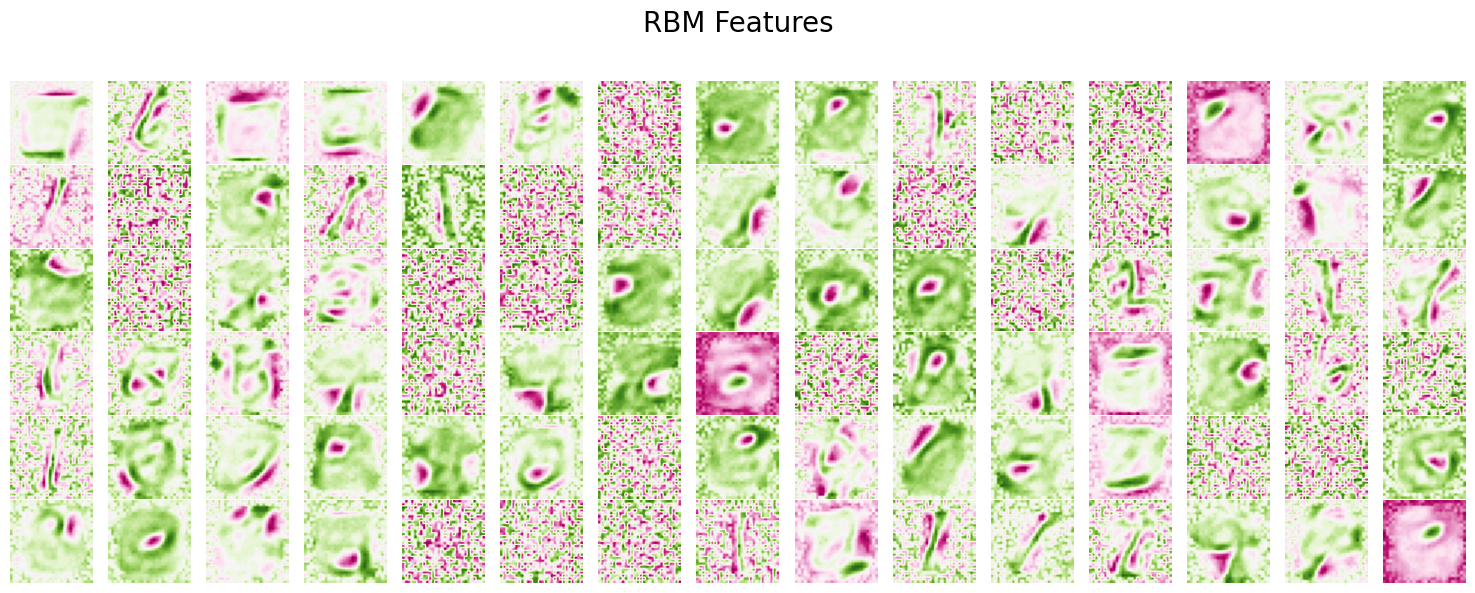

In [4]:
rbm.show_features()

In [5]:
# create dataset for NN using RBM
print("Creating datasets")
n_sample, sample_size = train_X.shape
encoded_train_X = np.empty((n_sample, rbm.n_hidden))
onehot_train_label = np.zeros((n_sample, 10))
for i in range(n_sample):
    _, _, _, vs_r = rbm.gibbs_sampling(train_X[i])
    hp_r, hs_r = rbm.foward(vs_r)
    encoded_train_X[i] = hs_r
    onehot_train_label[i][train_label[i]] = 1

n_sample, sample_size = test_X.shape
encoded_test_X = np.empty((n_sample, rbm.n_hidden))
for i in range(n_sample):
    _, _, _, vs_r = rbm.gibbs_sampling(test_X[i])
    hp_r, hs_r = rbm.foward(vs_r)
    encoded_test_X[i] = hs_r

Creating datasets


In [16]:
# create model
model = Sequential()
model.add(Dense(60, activation="tanh", input_shape=(rbm.n_hidden,)))
model.add(Dense(10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(encoded_train_X, onehot_train_label, batch_size=8, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
6750/6750 [==============================] - 4s 634us/step - loss: 0.4484 - accuracy: 0.8670 - val_loss: 0.2897 - val_accuracy: 0.9093
Epoch 2/10
6750/6750 [==============================] - 4s 614us/step - loss: 0.3381 - accuracy: 0.8939 - val_loss: 0.2621 - val_accuracy: 0.9170
Epoch 3/10
6750/6750 [==============================] - 4s 614us/step - loss: 0.3017 - accuracy: 0.9047 - val_loss: 0.2411 - val_accuracy: 0.9263
Epoch 4/10
6750/6750 [==============================] - 4s 633us/step - loss: 0.2763 - accuracy: 0.9124 - val_loss: 0.2282 - val_accuracy: 0.9260
Epoch 5/10
6750/6750 [==============================] - 4s 636us/step - loss: 0.2602 - accuracy: 0.9177 - val_loss: 0.2209 - val_accuracy: 0.9282
Epoch 6/10
6750/6750 [==============================] - 5s 675us/step - loss: 0.2481 - accuracy: 0.9209 - val_loss: 0.2187 - val_accuracy: 0.9320
Epoch 7/10
6750/6750 [==============================] - 4s 648us/step - loss: 0.2391 - accuracy: 0.9232 - val_loss: 0.2198 -

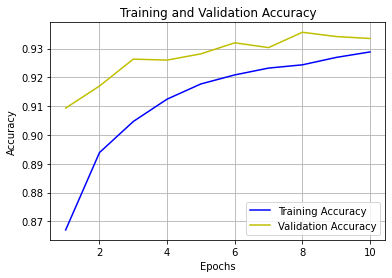

In [17]:
# Show train results
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

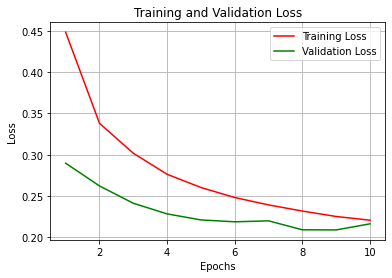

In [18]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [19]:
predictions = model.predict(encoded_test_X)
correct = 0
n_sample, size = predictions.shape
confusion_matrix = np.zeros((10, 10))
errors = {}
for i in range(predictions.shape[0]):
    pred = np.argmax(predictions[i])
    if pred == test_label[i]:
        correct += 1
    elif (pred, test_label[i]) in errors:
        errors[(pred, test_label[i])].append(i)
    else:
        errors[(pred, test_label[i])] = [i]
    confusion_matrix[pred][test_label[i]] += 1
print("Accuracy: ", correct/n_sample)

Accuracy:  0.9228


In [20]:
confusion_matrix

array([[9.500e+02, 0.000e+00, 8.000e+00, 2.000e+00, 2.000e+00, 8.000e+00,
        1.300e+01, 1.000e+00, 6.000e+00, 9.000e+00],
       [0.000e+00, 1.116e+03, 3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 1.100e+01, 1.000e+00, 4.000e+00],
       [1.000e+00, 3.000e+00, 9.810e+02, 2.100e+01, 6.000e+00, 1.000e+00,
        7.000e+00, 1.900e+01, 1.400e+01, 2.000e+00],
       [2.000e+00, 2.000e+00, 1.600e+01, 8.940e+02, 3.000e+00, 4.500e+01,
        0.000e+00, 6.000e+00, 2.400e+01, 1.400e+01],
       [0.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 8.780e+02, 2.000e+00,
        7.000e+00, 7.000e+00, 1.200e+01, 4.300e+01],
       [6.000e+00, 0.000e+00, 4.000e+00, 4.200e+01, 2.000e+00, 7.920e+02,
        1.400e+01, 3.000e+00, 2.400e+01, 1.400e+01],
       [1.000e+01, 3.000e+00, 2.000e+00, 2.000e+00, 9.000e+00, 9.000e+00,
        9.080e+02, 0.000e+00, 4.000e+00, 1.000e+00],
       [2.000e+00, 1.000e+00, 2.000e+00, 8.000e+00, 1.100e+01, 1.000e+00,
        0.000e+00, 9.600e+02, 9.000e+

In [21]:
for key, value in errors.items():
    print(key, value)

(6, 4) [33, 247, 1112, 1549, 1938, 3780, 3941, 4751, 9947]
(6, 2) [43, 1337]
(9, 4) [48, 198, 250, 295, 304, 565, 660, 707, 740, 752, 760, 881, 959, 1116, 1270, 1571, 1634, 2053, 2130, 2447, 2771, 2828, 2836, 3291, 3405, 3429, 3437, 3533, 3938, 4382, 4567, 4783, 4827, 4860, 4911, 4974, 4998, 5159, 5201, 5440, 5842, 5975, 6021, 6300, 6761, 6915, 6931, 6983, 6990, 6997, 7102, 7153, 7332, 7391, 8500, 8520, 8695, 8954, 9208, 9211, 9922]
(7, 9) [73, 320, 394, 882, 966, 1152, 1414, 1481, 1554, 1559, 1648, 3060, 3504, 3891, 3984, 4224, 4534, 4786, 5130, 5719, 6571, 6919, 7061, 7071, 7089, 7588, 7756, 7952, 8322, 9530, 9544, 9642, 9701, 9741, 9891]
(1, 7) [111, 1260, 1326, 1500, 2607, 3751, 3808, 3838, 3976, 7432, 8106]
(4, 9) [125, 788, 928, 1192, 1343, 1781, 1901, 2232, 2342, 2426, 2720, 2863, 2875, 2958, 3460, 3664, 3755, 3821, 3950, 3985, 4143, 4259, 4369, 4752, 4823, 5587, 6393, 6560, 6568, 6592, 6608, 6817, 6967, 7081, 7278, 7462, 7579, 7580, 7680, 9170, 9587, 9769, 9808]
(3, 2) [149, 13

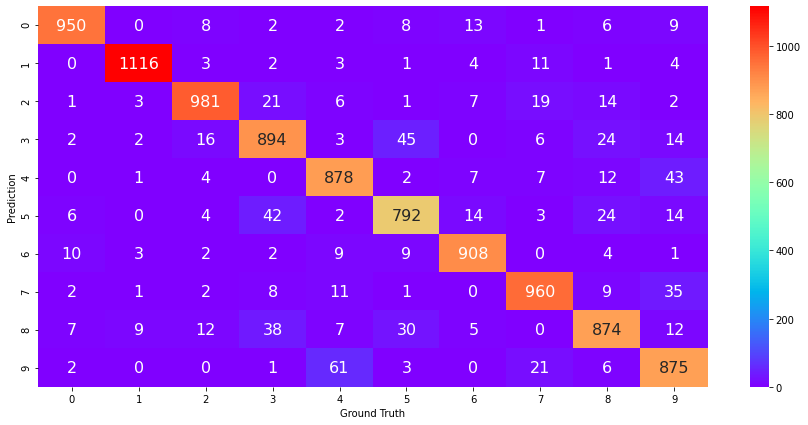

In [22]:
df_cm = pd.DataFrame(confusion_matrix, range(10), range(10))
# sn.set(font_scale=1.4) # for label size
plt.figure(figsize=(15,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=mat.cm.rainbow, fmt='g') # font size
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.show()

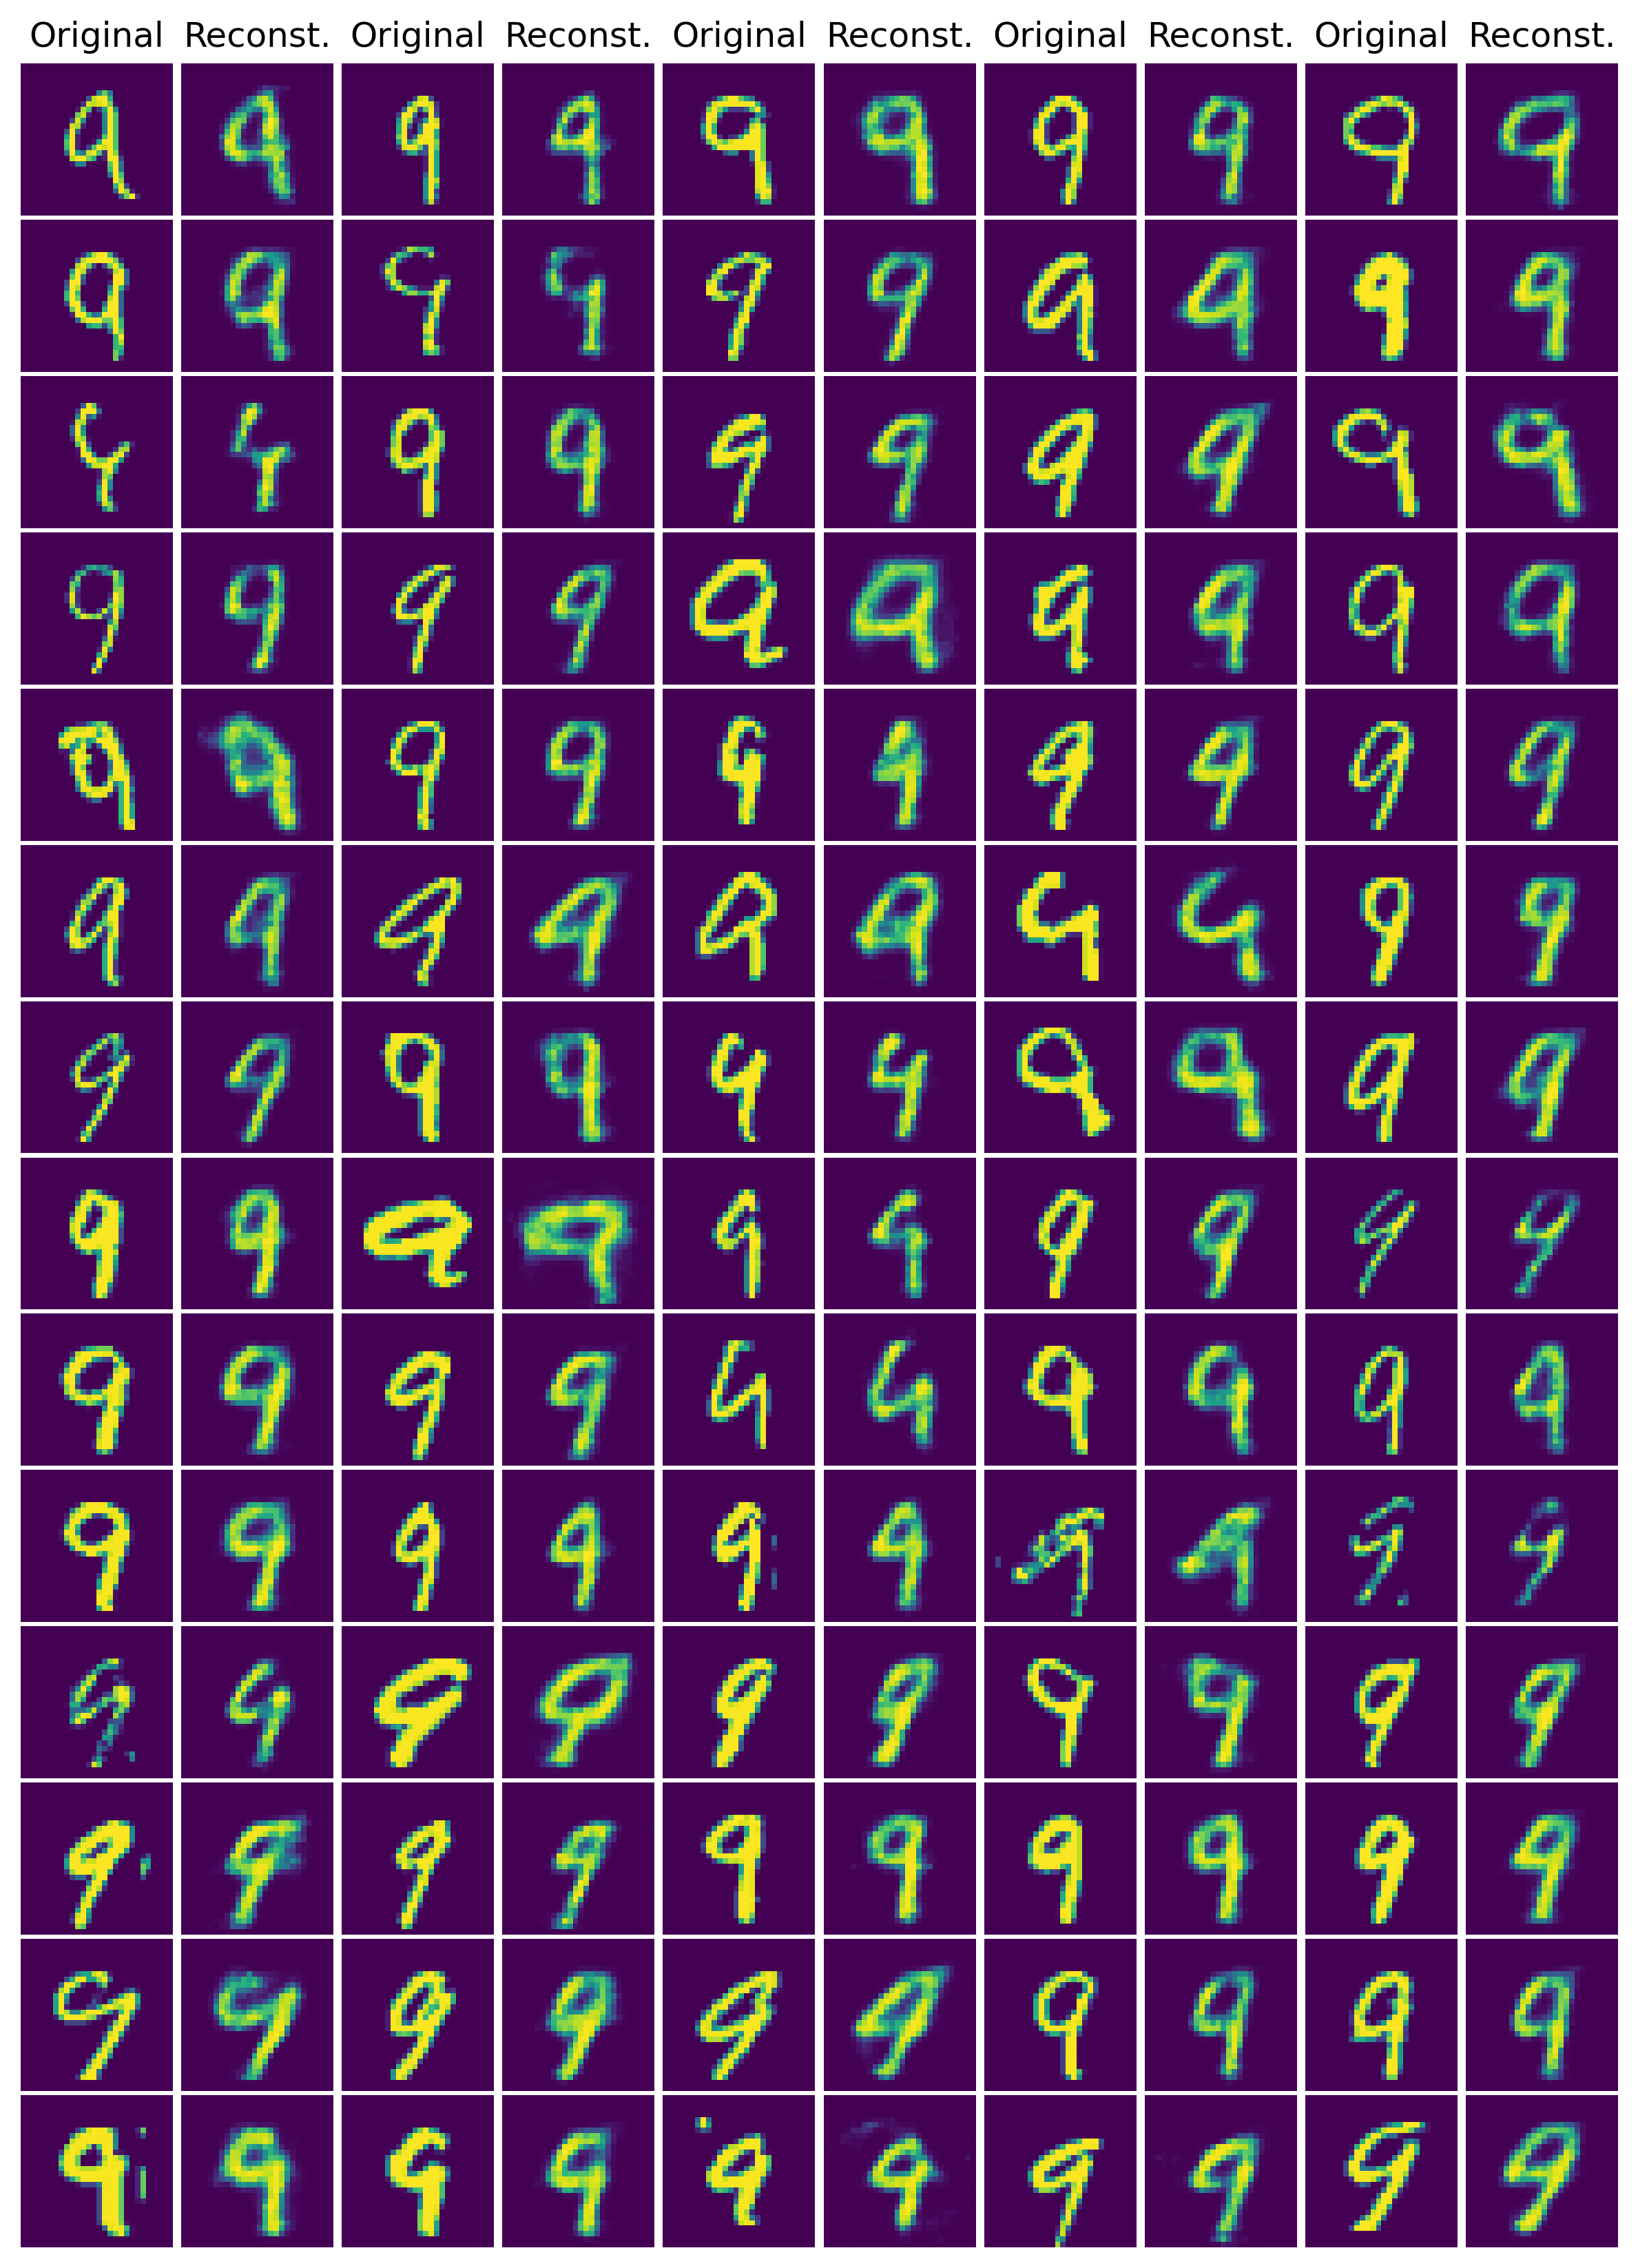

In [13]:
v = errors[(4,9)]
n = len(v)
ncols = 10
nrows = int(n/5)
fig = plt.figure(figsize=(ncols, nrows), dpi=300)
grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))
for i, ax in enumerate(grid):
    j = i//2
    if i%2 == 0:
        ax.imshow(mnist.vet2mat(test_X[v[j]]))
        if i<ncols:
            ax.set_title("Original")
    else:
        vp, _ = rbm.reconstruct(test_X[v[j]])
        ax.imshow(mnist.vet2mat(vp))
        if i<ncols:
            ax.set_title("Reconst.")
    ax.set_axis_off()   
plt.show()

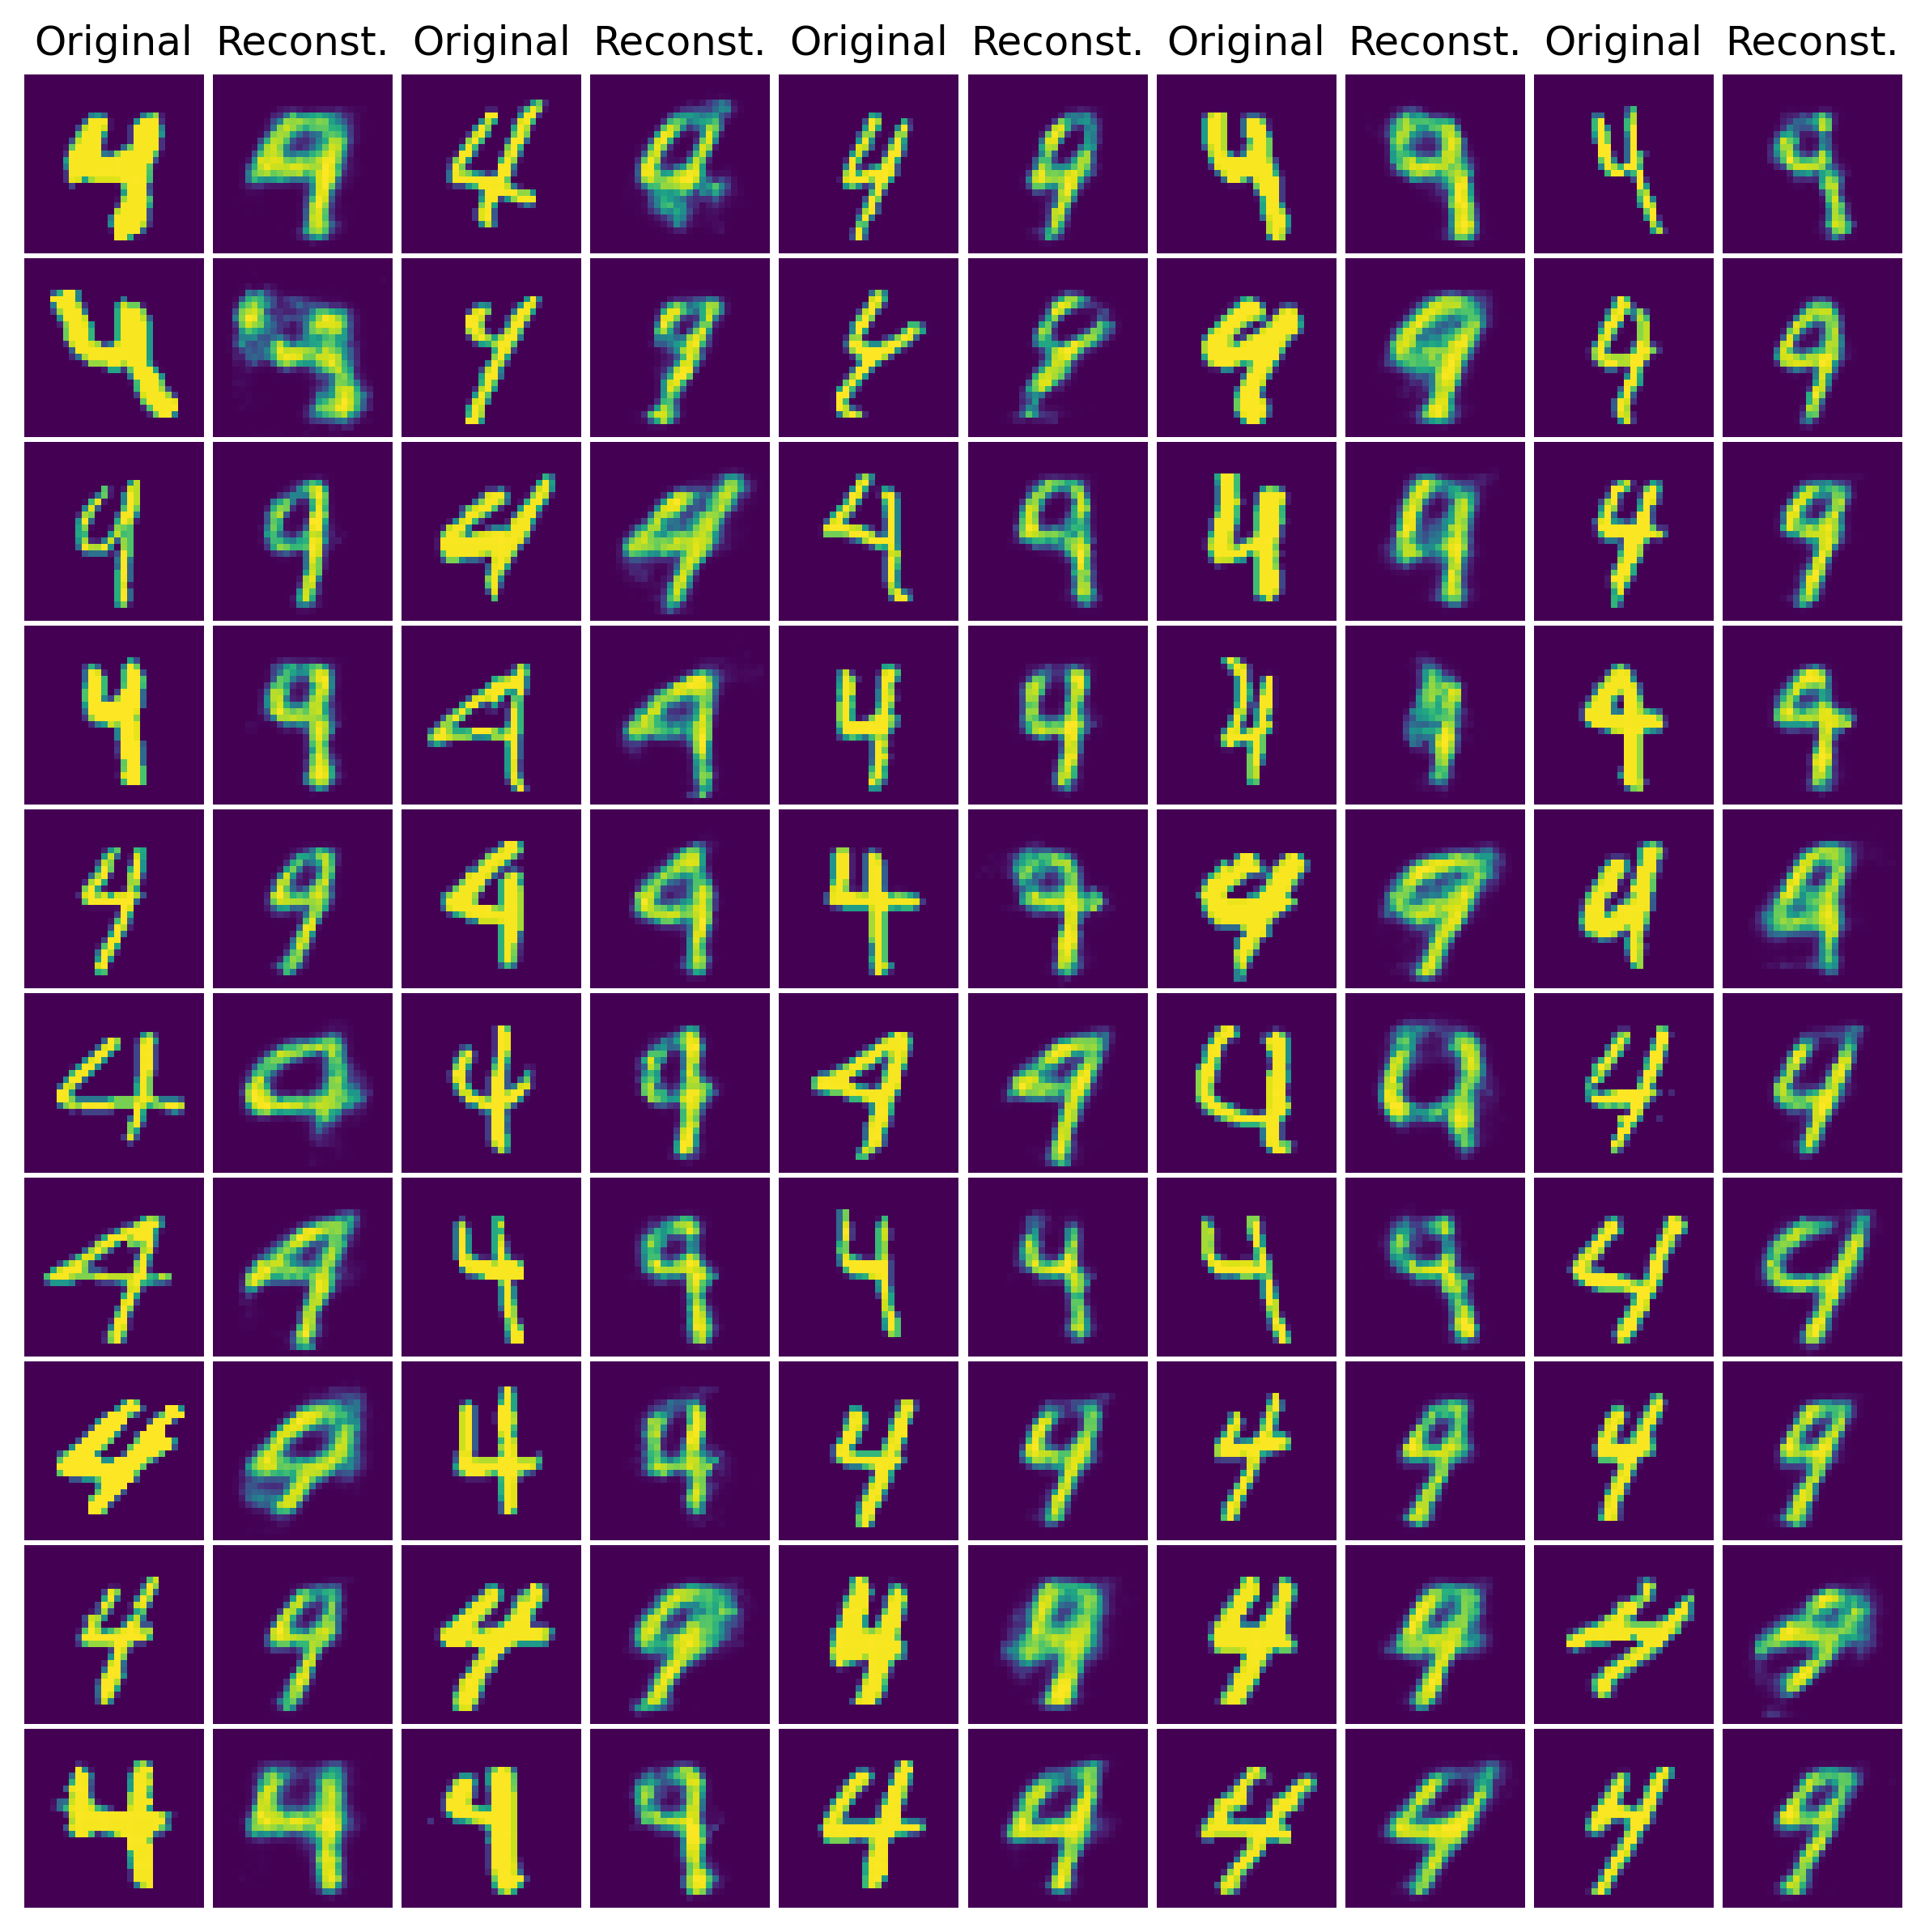

In [14]:
v = errors[(9,4)]
n = len(v)
ncols = 10
nrows = int(n/5)
fig = plt.figure(figsize=(ncols, nrows), dpi=300)
grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))
for i, ax in enumerate(grid):
    j = i//2
    if i%2 == 0:
        ax.imshow(mnist.vet2mat(test_X[v[j]]))
        if i<ncols:
            ax.set_title("Original")
    else:
        vp, _ = rbm.reconstruct(test_X[v[j]])
        ax.imshow(mnist.vet2mat(vp))
        if i<ncols:
            ax.set_title("Reconst.")
    ax.set_axis_off()   
plt.show()

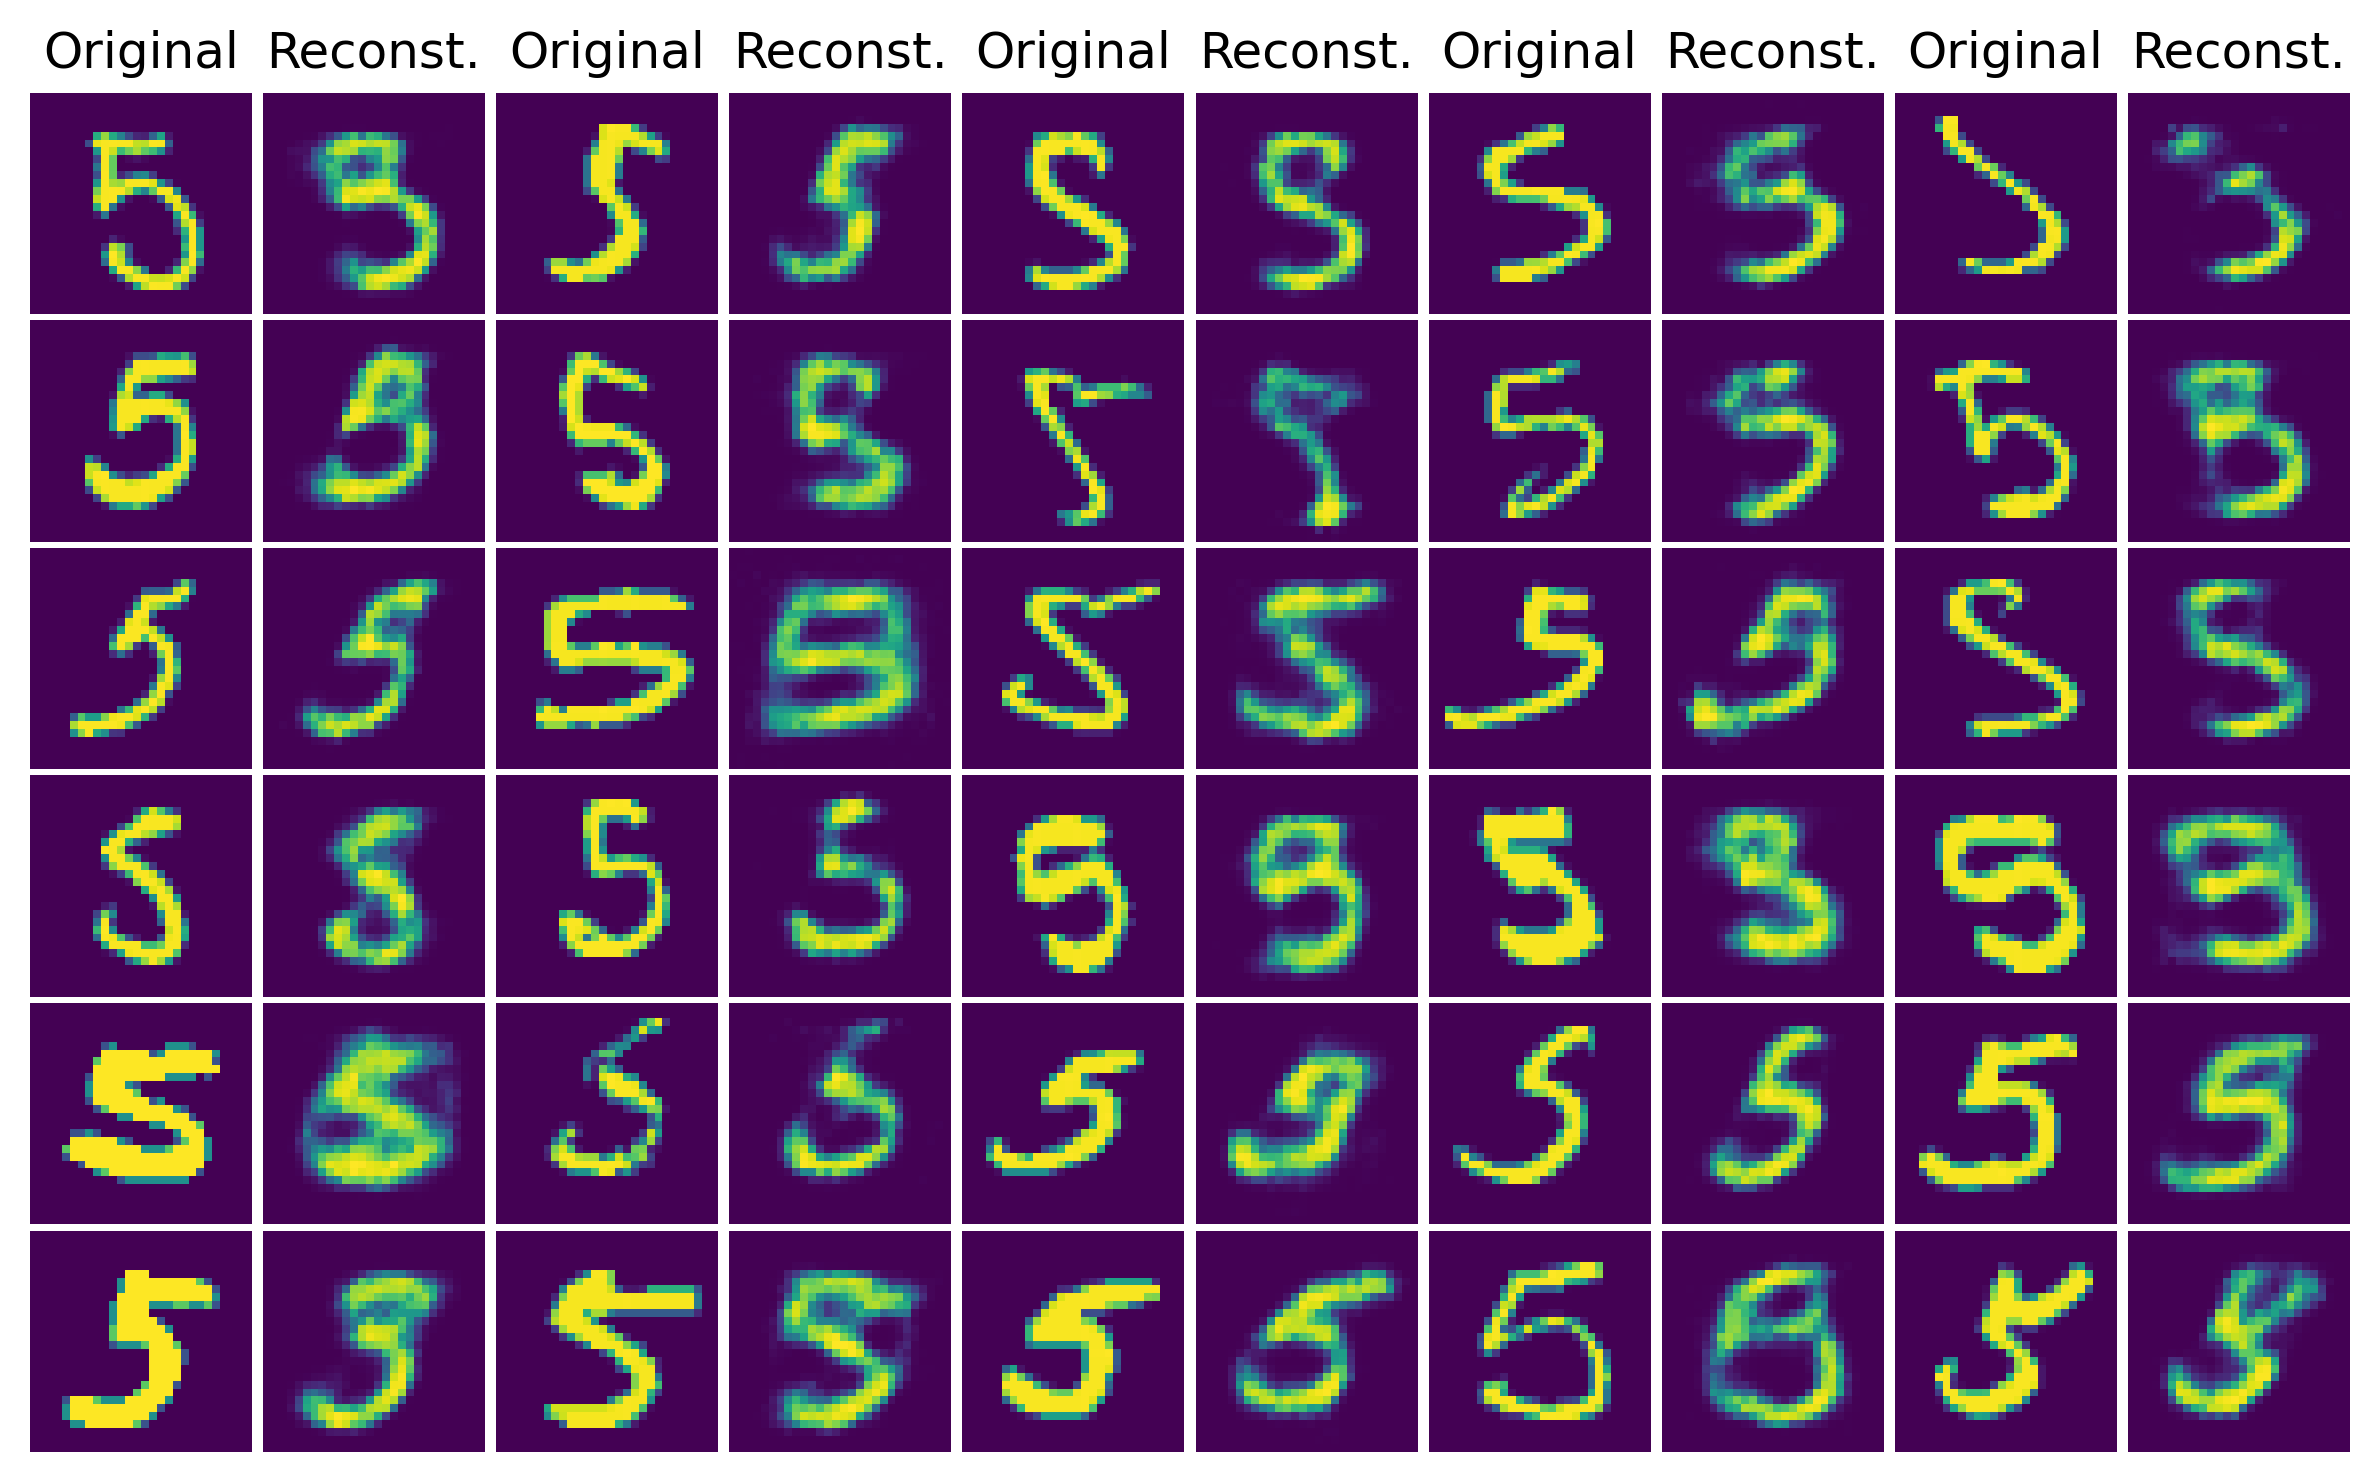

In [15]:
v = errors[(3,5)]
n = len(v)
ncols = 10
nrows = int(n/5)
fig = plt.figure(figsize=(ncols, nrows), dpi=300)
grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))
for i, ax in enumerate(grid):
    j = i//2
    if i%2 == 0:
        ax.imshow(mnist.vet2mat(test_X[v[j]]))
        if i<ncols:
            ax.set_title("Original")
    else:
        vp, _ = rbm.reconstruct(test_X[v[j]])
        ax.imshow(mnist.vet2mat(vp))
        if i<ncols:
            ax.set_title("Reconst.")
    ax.set_axis_off()   
plt.show()

In [27]:
model.save("models/RBM_classifier")

INFO:tensorflow:Assets written to: models/RBM_classifier\assets


In [38]:
d = {'n_v':rbm.n_visible, 'n_h':rbm.n_hidden, 'W':rbm.W, 'hb':rbm.hb, 'vb':rbm.vb, 'k':rbm.k}
save_file = "RBM."+ str(rbm.n_visible) + "x" + str(rbm.n_hidden)
with open(save_file, 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)